# In-depth analysis I

We are using the merged and cleaned dataframe made of original csv files with features df_final.csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_final = pd.read_csv("df_final.csv")
df_final['Date'] = pd.to_datetime(df_final['Date'])

df_final['Date'] = df_final['Date'].dt.date



## Performing feature engineering

### Feature selection: dropping unnecessary columns 

**Reasoning for the choice of columns:**
- "HolidayNames" is the column that can substitute columns "IsHoliday", "Super_Bowl", "Labor_Day", "Thanksgiving", "Christmas" -> preventing multicollinearity
- Description -> we alredy have department column


In [ ]:
df_final.drop(columns=["IsHoliday", "Super_Bowl", "Labor_Day", 
                                                    "Thanksgiving", "Christmas", "Description"], inplace = True)
df_final.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,HolidayNames,Type,Size,Year,Month,Day
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,Not a holiday,A,151315,2010,2,5
1,1,1,2010-02-12,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,Superbowl,A,151315,2010,2,12
2,1,1,2010-02-19,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,Not a holiday,A,151315,2010,2,19
3,1,1,2010-02-26,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,Not a holiday,A,151315,2010,2,26
4,1,1,2010-03-05,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,Not a holiday,A,151315,2010,3,5


## Identifiying and filling in missing values 

In [ ]:
missing = pd.DataFrame(df_final.isna().sum(), columns=["Missing Values Counts"])
missing

,Missing Values Counts
Store,0
Dept,0
Date,0
Weekly_Sales,0
Temperature,0
Fuel_Price,0
MarkDown1,270883
MarkDown2,310312
MarkDown3,284471
MarkDown4,286597


Here we can see that only columns "Markdowns" contain missing values. To decide whether to fill them in with mean or median, let's check the distribution and see if these features are normally distributed or do they contain outliers.

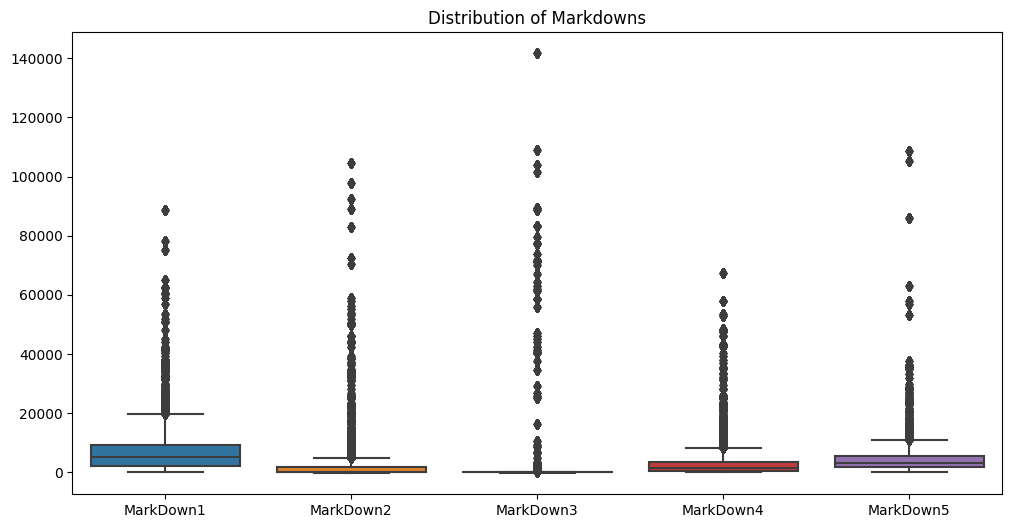

In [ ]:
import seaborn as sns
markdowns_columns = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

plt.figure(figsize=(12, 6))
sns.boxplot(df_final[markdowns_columns])
plt.title("Distribution of Markdowns")
plt.show()

Because there are many outliers in the data, we should replace missing values with median since it is less affected by outliers. However, before doing so, let's also check the distribution of missing values in markdowns by years, taking into account that the amount of missing values in markdowns is more than half compared to the whole dataset. Filling them with just median would significantly affect the results of our analysis and won't realistically represent the dataset.

/tmp/ipykernel_610/1995121240.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_yearmonth['YearMonth'] = pd.to_datetime(missing_yearmonth['Date']).dt.to_period('M')


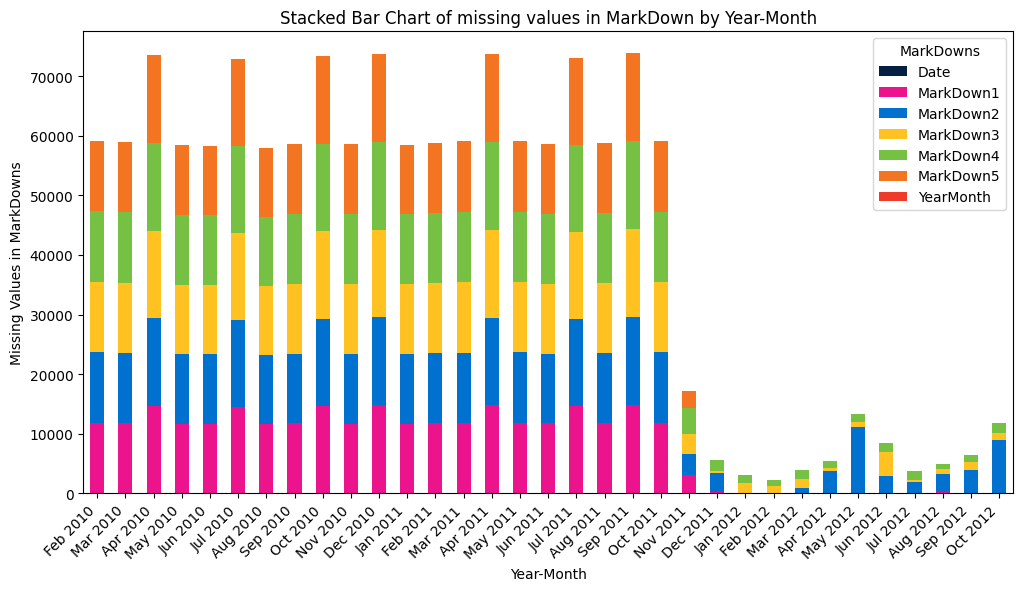

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

selected_columns = ["Date", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]
missing_yearmonth = df_final[selected_columns]

# Assuming you want to group by years and months
missing_yearmonth['YearMonth'] = pd.to_datetime(missing_yearmonth['Date']).dt.to_period('M')
missing_yearmonth = missing_yearmonth.groupby(['YearMonth']).apply(lambda x: x.isnull().sum())


colors = ['#041f41', '#eb148d', '#0071ce', '#ffc220', "#76c043", "#f47521", "#ee3b2a"]

# Plotting the stacked bar chart
ax = missing_yearmonth.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Formatting x-ticks to display years and months
years = missing_yearmonth.index.strftime('%Y')
months = missing_yearmonth.index.strftime('%b %Y')
ax.set_xticks(range(len(missing_yearmonth)))
ax.set_xticklabels(months, rotation=45, ha='right')

plt.xlabel("Year-Month")
plt.ylabel("Missing Values in MarkDowns")
plt.title("Stacked Bar Chart of missing values in MarkDown by Year-Month")
plt.legend(title="MarkDowns")
plt.show()

As we can see, the majority of missing values in the markdowns are located in the period from February 2010 till October 2011. To maintain data quality, we should exclude this period from our analysis, by dropping it. However, this is a huge amount of data, and dropping it will lead to us loosing almost 2 years of observation. We would prefer to keep as much of these months in the final dataset we'll use to train and test our models on as poossible, at the same time not letting the missing values all thogether be more than 25% of the dataset (otherwise, it's affecting the distribution, making the whole range of each markdown to squish to its' median). Thus, our main goal now is to find the "breaking point" between the February of 2010 and October of 2011 - a month that will split period of high missing values into the part that we will drop and the part that we'll keep and fill in with median. 

In [ ]:
missing_yearmonth.drop(columns=["Date", "YearMonth"], axis=1, inplace=True)
missing_yearmonth.head()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
YearMonth,,,,,
2010-02,11837,11837,11837,11837,11837
2010-03,11786,11786,11786,11786,11786
2010-04,14697,14697,14697,14697,14697
2010-05,11671,11671,11671,11671,11671
2010-06,11661,11661,11661,11661,11661


In [ ]:
#calculate the percentage that each month's missing values are relatively to the number of datapoint in the whole
#dataset: in other words, the "price" of dropping this month from our dataset (if we drop this month,
#how much of the data we'll loose?)

missing_yearmonth["%"] = (missing_yearmonth.max(axis=1) / df_final.shape[0]) * 100
missing_yearmonth

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,%
YearMonth,,,,,,
2010-02,11837,11837,11837,11837,11837,2.807944
2010-03,11786,11786,11786,11786,11786,2.795846
2010-04,14697,14697,14697,14697,14697,3.486386
2010-05,11671,11671,11671,11671,11671,2.768566
2010-06,11661,11661,11661,11661,11661,2.766194
2010-07,14561,14561,14561,14561,14561,3.454125
2010-08,11603,11603,11603,11603,11603,2.752435
2010-09,11724,11724,11724,11724,11724,2.781138
2010-10,14667,14667,14667,14667,14667,3.479270


In [ ]:
#now we can calculate the % of missing data relative to all the data we have to check if everything is correct
all_missing_ratio = missing_yearmonth["%"].sum()
all_missing_ratio

74.89384515388302

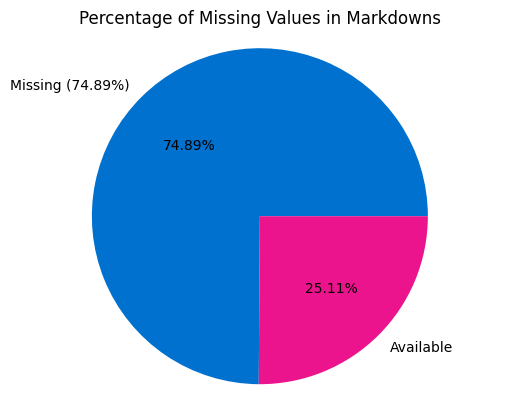

In [ ]:

missing_angle = 360 * (all_missing_ratio / 100)

# Create a pie chart
fig, ax = plt.subplots()
ax.pie([missing_angle, 360 - missing_angle], labels=[f"Missing (74.89%)", "Available"], autopct='%1.2f%%', colors=['#0071CE', '#EB148D', '#FFC220'])

# Draw a circle in the center to represent the entire dataset
circle = plt.Circle((0, 0), 0.6, color='white')


# Equal aspect ratio ensures that the pie is drawn as a circle.
ax.axis('equal')

# Title
plt.title("Percentage of Missing Values in Markdowns")

# Show the plot
plt.show()

So, missing values are 74.89% of all the dataset. As we explained earlier, from this amount, we are dropping 75% and keeping 25% to fill in with median -> this way we won't let the median overpower the real datapoints and the overall distribution, at the same time saving as much data as possible. 

To define 75% of the missing values, which are stored in missing_yearmonth , we'll create a variable missing_to_drop that we'll store the borderline, and through loop find the month that will cut 75% of missing values that we'll drop. 

In [ ]:
# 75% of  74.89% of the dataset which are missing values that we want to drop 

missing_to_drop = 0.75 * all_missing_ratio
missing_to_drop

56.17038386541226

In [ ]:
#here we are looking for the "breaking point" that we mentioned above: the month, before which we'll drop the data

missing_less_half = 0 # a "counter" of how much % of data we lost dropping the months in chronological order

for i in missing_yearmonth.index:
    if missing_less_half < missing_to_drop: 
        missing_less_half += missing_yearmonth["%"][i]
    else:
        print(f"The month and year before which we'll drop the data: {i}")
        break                   # once the amount of data we've dropped became more than 50% of our whole dataset 
                                # we want to stop dropping the columns and "catch" the month when it happened:
                                # this is the breaking point we were looking for 

The month and year before which we'll drop the data: 2011-09


We figured, that we should to preserve as many holiday sales as possible, however we dont want to  keep more than 75% of the missing data. With this method we are able to keep all !!!!! explain about labor day

In [ ]:
#drop all the data before September  2011
from datetime import datetime

df_final['Date'] = pd.to_datetime(df_final['Date']).dt.date

df_final = df_final[df_final['Date'] > datetime(2011, 9, 1).date()]

In [ ]:
#the 25% of preserved missing values
df_final.isna().sum()

Store               0
Dept                0
Date                0
Weekly_Sales        0
Temperature         0
Fuel_Price          0
MarkDown1       30286
MarkDown2       69715
MarkDown3       43874
MarkDown4       46000
MarkDown5       29535
CPI                 0
Unemployment        0
HolidayNames        0
Type                0
Size                0
Year                0
Month               0
Day                 0
dtype: int64

In [ ]:
# we don't need the date column anymore, so let's drop it and fill the rest of the missing 
#values with median as explained above

df_final.drop(columns=["Date"], inplace = True)

df_final.fillna(df_final.median(), inplace=True)

df_final.isna().sum()

Store           0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
HolidayNames    0
Type            0
Size            0
Year            0
Month           0
Day             0
dtype: int64

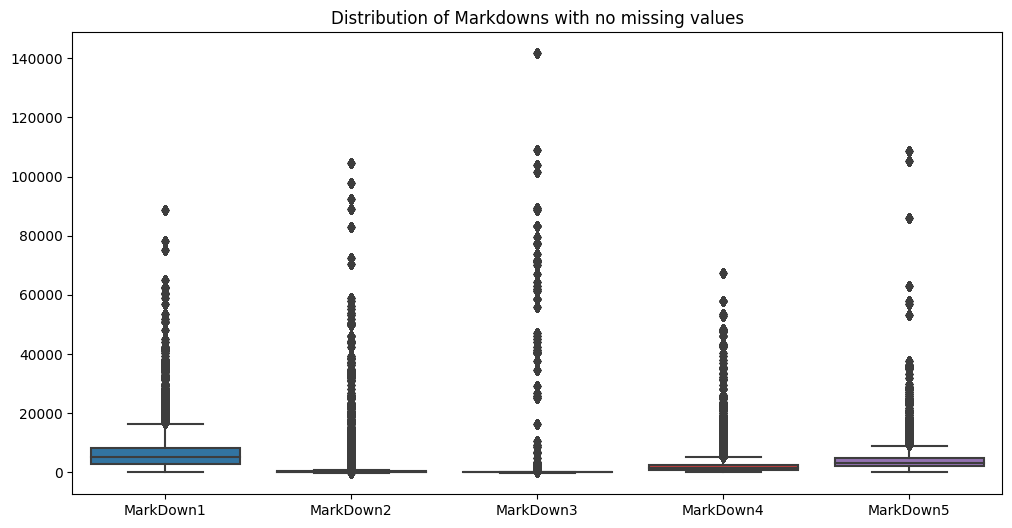

In [ ]:
#check the distribution of markdowns after handling missing values 

plt.figure(figsize=(12, 6))
sns.boxplot(df_final[markdowns_columns])
plt.title("Distribution of Markdowns with no missing values")
plt.show()

Now the dataset has no missing values.

## Handling outliers

Outliers can seriously affect the performance of machine learning models. Models like linear regression are sensitive to extreme values, leading to a poor fit and inaccurate predictions, so we have to address them before processing to the next steps. Let's explore the features to see which of them have outliers.

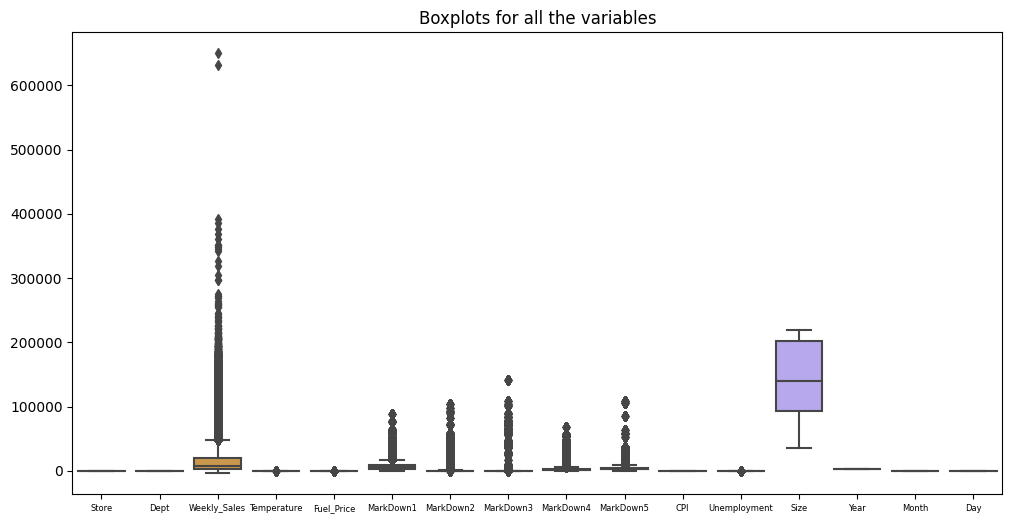

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(df_final)
plt.title("Boxplots for all the variables")
plt.xticks(fontsize=6)
plt.show()

The boxplots show that features "Markdown1", "Markdown2", "Markdown3", "Markdown4", "Markdown5", "Temperature", ""Fuel_Price", Unemployment" as well as target variable "Weekly_Sales" contain a lot of outliers. Since the data is not normally distributed, we will use the Interquartile Range Method of outliers removal.

Let's deal with the Markdowns at first. We've noticed that the markdowns are exceptionally high, so while removing the outliers without taking this into consideration, we are removing christmas information from the dataset completelly. To prevent that, let's exclude the Christmas rows from the dataset for Markdowns outliers removing process, and then add them back, to have a reallistic representation of the markdowns during all 4 types of holidays.

In [ ]:
#exclude christmas from df_final for outliers removal
df_non_christmas = df_final[df_final["HolidayNames"] != "Christmas"]

# remove outliers for the non-Christmas rows
for markdown in markdowns_columns:
    Q1 = df_non_christmas[markdown].quantile(0.25)
    Q3 = df_non_christmas[markdown].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_non_christmas = df_non_christmas[(df_non_christmas[markdown] >= lower_bound) & (df_non_christmas[markdown] <= upper_bound)]

# in df_final join the non-outliers data and christmas rows
df_final = pd.concat([df_final[df_final["HolidayNames"] == "Christmas"], df_non_christmas])

df_final.head()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,HolidayNames,Type,Size,Year,Month,Day
99,1,1,23350.88,44.55,3.129,5762.1,46011.38,260.36,983.65,4735.78,219.53599,7.866,Christmas,A,151315,2011,12,30
242,1,2,43539.94,44.55,3.129,5762.1,46011.38,260.36,983.65,4735.78,219.53599,7.866,Christmas,A,151315,2011,12,30
385,1,3,8848.44,44.55,3.129,5762.1,46011.38,260.36,983.65,4735.78,219.53599,7.866,Christmas,A,151315,2011,12,30
528,1,4,37371.22,44.55,3.129,5762.1,46011.38,260.36,983.65,4735.78,219.53599,7.866,Christmas,A,151315,2011,12,30
671,1,5,34981.76,44.55,3.129,5762.1,46011.38,260.36,983.65,4735.78,219.53599,7.866,Christmas,A,151315,2011,12,30


'weekly sales max'

221834.28

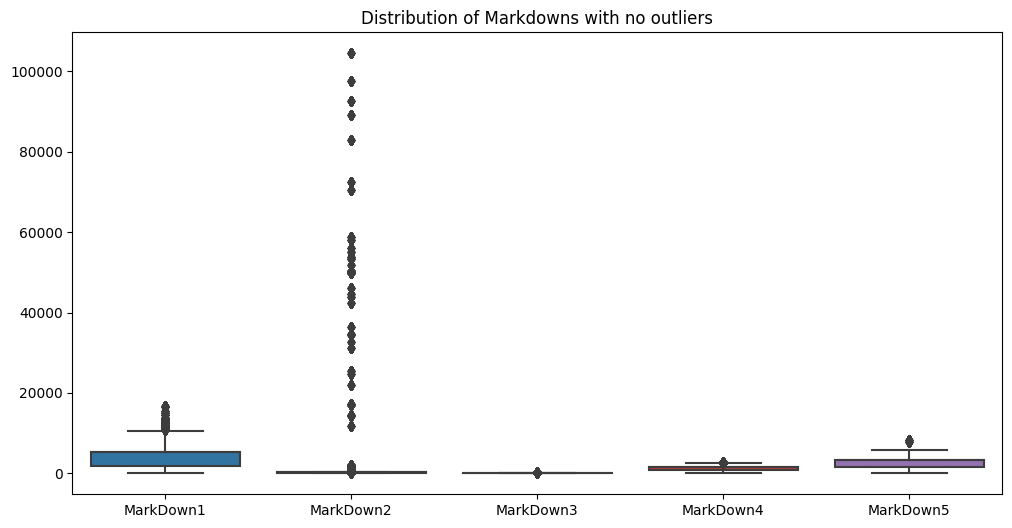

In [ ]:
display('weekly sales max',df_final['Weekly_Sales'].max())
plt.figure(figsize=(12, 6))
sns.boxplot(df_final[markdowns_columns])
plt.title("Distribution of Markdowns with no outliers")
plt.show()

Now with the rest of the features:

In [ ]:
outliers_columns = ["Temperature", "Fuel_Price", "Unemployment"]

In [ ]:
for column in outliers_columns:
    Q1 = df_final[column].quantile(0.25)
    Q3 = df_final[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_final = df_final[(df_final[column] >= lower_bound) & (df_final[column] <= upper_bound)]

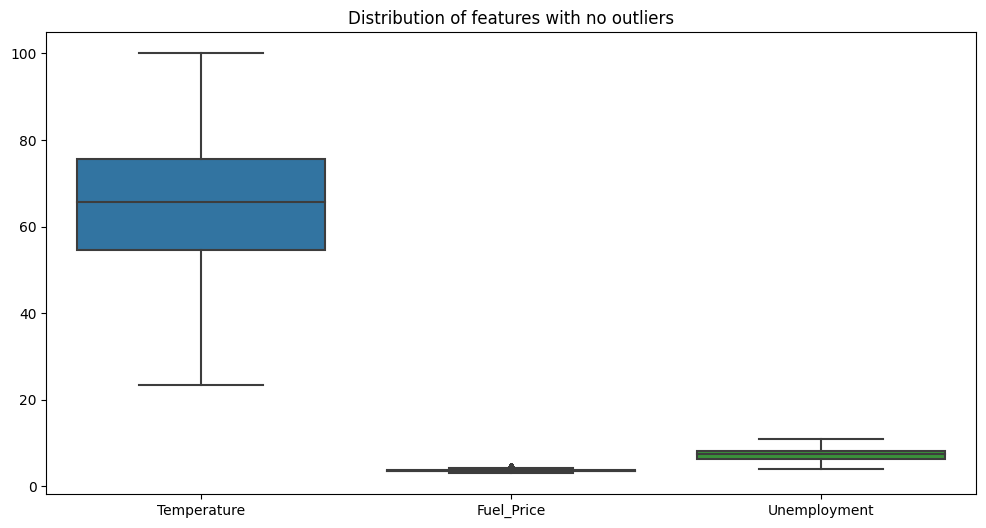

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(df_final[outliers_columns])
plt.title("Distribution of features with no outliers")
plt.show()

And finally, outliers in the Weekly Sales. We believe, we shouldn't remove the outliers in the target variable using IQR method because the outliers mostly are not results of mistakes during the data collection process, but the extreme values of sales earned by Walmart during holidays. To check if our hypothesis is correct, we've decided to observe and compare the max values of the sales overall and the max values of sales during the holidays.

To do so, let's at first perform data encoding:

## One-hot encoding

In this dataset, we have 2 

In [ ]:
#dummies -> type, holidaynames
display('weekly sales max',df_final['Weekly_Sales'].max())
df_final = pd.get_dummies(df_final, columns=["Type", "HolidayNames"], prefix=["Type", "Holiday"], drop_first=False)

df_final.describe()

'weekly sales max'

221834.28

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month,Day,Type_A,Type_B,Type_C,Holiday_Christmas,Holiday_Labor Day,Holiday_Not a holiday,Holiday_Superbowl,Holiday_Thanksgiving
count,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,...,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000,82119.000000
mean,23.330131,44.393417,13313.964113,64.747653,3.652962,4218.435738,1476.656339,25.601135,1227.806898,2674.253520,...,7.820577,17.108099,0.405339,0.418819,0.175842,0.030748,0.052022,0.908815,0.004238,0.004177
std,13.461576,30.995605,19512.627832,14.437756,0.247916,2826.432497,8949.215057,36.525161,612.569050,1243.630043,...,2.704736,9.035884,0.490960,0.493369,0.380688,0.172635,0.222073,0.287873,0.064960,0.064494
min,1.000000,1.000000,-3924.000000,23.410000,3.056000,0.270000,-10.980000,-0.870000,0.410000,153.040000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,17.000000,1299.950000,54.680000,3.509000,1887.950000,121.670000,6.130000,811.410000,1605.340000,...,6.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,23.000000,38.000000,5929.370000,65.790000,3.638000,5347.450000,192.000000,24.600000,1481.310000,3330.230000,...,9.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,35.000000,74.000000,16909.445000,75.690000,3.814000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,...,10.000000,26.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,45.000000,99.000000,221834.280000,100.070000,4.308000,16717.380000,104519.540000,406.400000,2828.890000,8337.700000,...,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Weekly Sales outliers removal 

With previous columns we have removed outlier with the quartile method. It has come across the problem that it is important to consider the holidays where an outlier could be very important for the predictive model regarding holiday sales. For this, a separate dataframe df_holiday_yes has been created for all the features to be set on the holiday dates. This way we can analyse the weekly sales on only those holidays. 

To approach this problem we have to compare the maximum sale of the holiday with the maximum sale of the overal dataset. Therefore we compare the dataframe : df_holiday_yes    with the dataframe: df_final.

'laborday:'

count      4272.000000
mean      15261.721077
std       22051.697063
min        -486.270000
25%        1856.840000
50%        7045.765000
75%       19064.837500
max      214448.960000
Name: Weekly_Sales, dtype: float64

'christmas:'

count      2525.000000
mean      15606.744178
std       20700.298705
min        -798.000000
25%        2057.410000
50%        7562.110000
75%       21363.670000
max      156431.460000
Name: Weekly_Sales, dtype: float64

'superbowl:'

count       348.000000
mean       9365.511494
std       16241.656430
min           1.000000
25%         137.937500
50%        1110.105000
75%       11544.277500
max      110379.120000
Name: Weekly_Sales, dtype: float64

'thanksgiving:'

count       343.000000
mean       9097.138746
std       15869.805188
min        -169.980000
25%         115.500000
50%        1095.710000
75%       11908.035000
max      102374.270000
Name: Weekly_Sales, dtype: float64

'weekly sales original'

count     82119.000000
mean      13313.964113
std       19512.627832
min       -3924.000000
25%        1299.950000
50%        5929.370000
75%       16909.445000
max      221834.280000
Name: Weekly_Sales, dtype: float64

'max holiday sale:'

214448.96

'maxsale:'

221834.28

<AxesSubplot: >

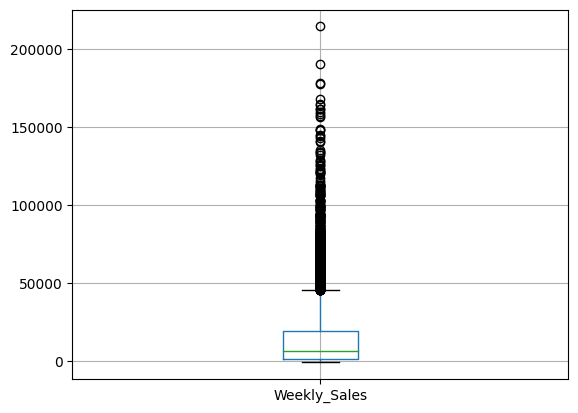

In [ ]:
# we created a dataframe where we can see the weekly sales for only the holidays called df_holiday_yes


df_holiday_yes = df_final[df_final['Holiday_Not a holiday']==0]
laborday_sales = df_holiday_yes[df_holiday_yes['Holiday_Labor Day']==1]
display('laborday:',laborday_sales['Weekly_Sales'].describe())

# Here the distribution of the weekly sales in the christmas holidays are displayed
christmas_sales = df_holiday_yes[df_holiday_yes['Holiday_Christmas']==1]
display('christmas:',christmas_sales['Weekly_Sales'].describe())

# Here the distribution of the weekly sales in the superbowl holidays are displayed
superbowl_sales = df_holiday_yes[df_holiday_yes['Holiday_Superbowl']==1]
display('superbowl:',superbowl_sales['Weekly_Sales'].describe())

# Here the distribution of the weekly sales in the thanksgiving holidays are displayed
thanksgiving_sales = df_holiday_yes[df_holiday_yes['Holiday_Thanksgiving']==1]
display('thanksgiving:',thanksgiving_sales['Weekly_Sales'].describe())


# Here the distribution of the weekly sales of the whole dataset (df_final) are displayed
display('weekly sales original',df_final['Weekly_Sales'].describe())

# here the max holiday sales and the max sales are compared to see where we should cut the dataset. 
display('max holiday sale:',df_holiday_yes['Weekly_Sales'].max() )
display('maxsale:',df_final['Weekly_Sales'].max() )
df_holiday_yes[['Weekly_Sales']].boxplot()
# 

In [ ]:
df_final = df_final[df_final['Weekly_Sales']<= df_holiday_yes['Weekly_Sales'].max()]
df_final['Weekly_Sales'].max()

214448.96

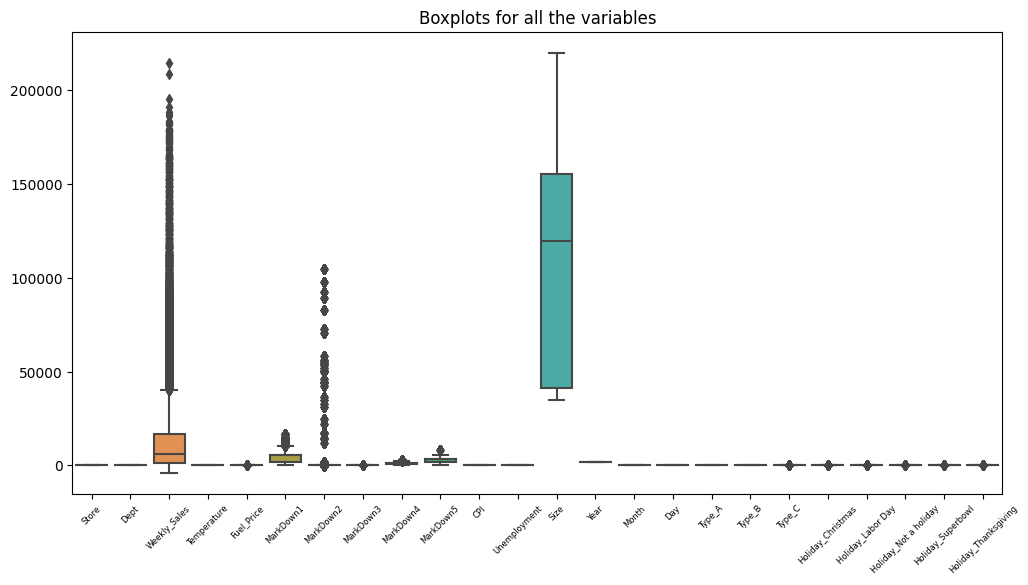

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(df_final)
plt.title("Boxplots for all the variables")
plt.xticks(fontsize=6, rotation=45)
plt.show()

Now the dataset doesn't contain any outliers that are a result of mistake, only real extreme values

## Scaling

The last step before regression analysis is to scale the variables. We are going to create 2 versions of this dataset: scaled and unscaled, and compare which one performs better in regression model.

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()

#create 2 versions of the dataframe
df_final_standardized = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)
df_final_unscaled = df_final.copy()


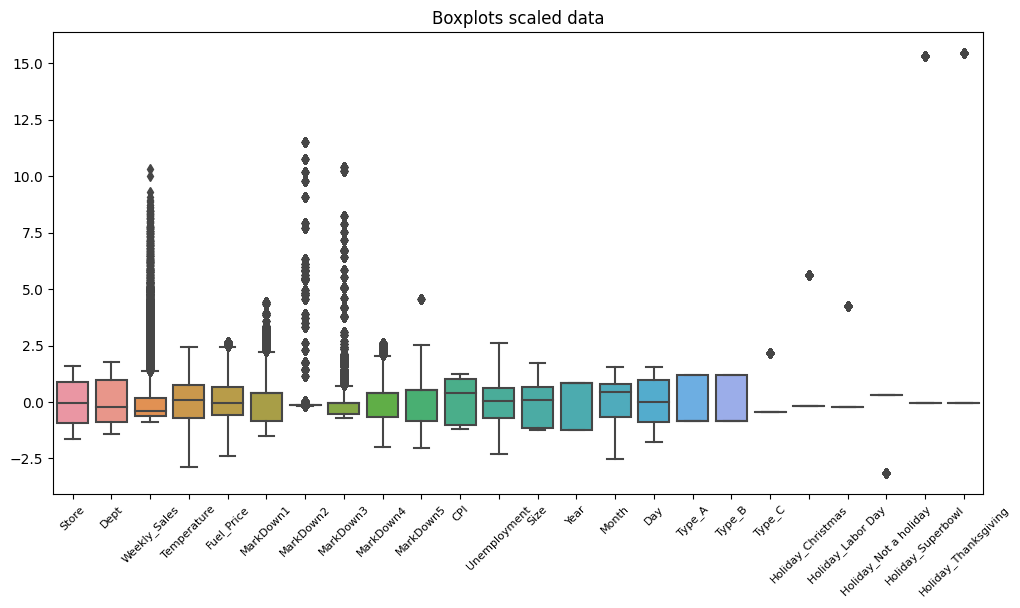

In [ ]:
#check the dataset after scaling
plt.figure(figsize=(12, 6))
sns.boxplot(df_final_standardized)
plt.title("Boxplots scaled data")
plt.xticks(fontsize=8, rotation=45)
plt.show()

## Regression Analysis

### Linear Regression, Ridge and Lasso (first attempt)

Now we have two versions of the same dataset: scaled and unscaled. We are going to train and test different regression models on both of them and compare the results to see: a) which model performs the best on this specific dataset, and b) on scaled or unscaled data

### Scaled

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

print("Scaled data")

#split the data into train and test splits
X = df_final_standardized.drop("Weekly_Sales", axis=1)
y = df_final_standardized["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit the data into linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

#Make predictions on train and test data
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

#Calculate R-squared scores
r_squared_score_train = r2_score(y_train, y_pred_train)
r_squared_score_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression train score: {r_squared_score_train:.4f} Linear Regression test score: {r_squared_score_test:.4f}")

#fit the data into ridge and lasso
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1) 
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

#Make predictions on train data
y_pred_train_ridge = ridge.predict(X_train)
y_pred_train_lasso = lasso.predict(X_train)

#Make predictions on test data
y_pred_test_ridge = ridge.predict(X_test)
y_pred_test_lasso = lasso.predict(X_test)

#Calculate R2 scores
r_squared_score_train_ridge = r2_score(y_train, y_pred_train_ridge)
r_squared_score_test_ridge = r2_score(y_test, y_pred_test_ridge)
r_squared_score_train_lasso = r2_score(y_train, y_pred_train_lasso)
r_squared_score_test_lasso = r2_score(y_test, y_pred_test_lasso)

print(f"Ridge train score: {r_squared_score_train_ridge:.4f} Ridge test score: {r_squared_score_test_ridge:.4f}")
print(f"Lasso train score: {r_squared_score_train_lasso:.4f} Lasso test score: {r_squared_score_test_lasso:.4f}")

   

Scaled data
Linear Regression train score: 0.1063 Linear Regression test score: 0.1082
Ridge train score: 0.1064 Ridge test score: 0.1082
Lasso train score: 0.0763 Lasso test score: 0.0760


### Unscaled

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

print("Unscaled data")

#split the data into train and test splits
X = df_final_unscaled.drop("Weekly_Sales", axis=1)
y = df_final_unscaled["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit the data into linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

#Make predictions on train and test data
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

#Calculate R-squared scores
r_squared_score_train = r2_score(y_train, y_pred_train)
r_squared_score_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression train score: {r_squared_score_train:.4f} Linear Regression test score: {r_squared_score_test:.4f}")

#fit the data into ridge and lasso
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1) 
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

#Make predictions on train data
y_pred_train_ridge = ridge.predict(X_train)
y_pred_train_lasso = lasso.predict(X_train)

#Make predictions on test data
y_pred_test_ridge = ridge.predict(X_test)
y_pred_test_lasso = lasso.predict(X_test)

#Calculate R2 scores
r_squared_score_train_ridge = r2_score(y_train, y_pred_train_ridge)
r_squared_score_test_ridge = r2_score(y_test, y_pred_test_ridge)
r_squared_score_train_lasso = r2_score(y_train, y_pred_train_lasso)
r_squared_score_test_lasso = r2_score(y_test, y_pred_test_lasso)

print(f"Ridge train score: {r_squared_score_train_ridge:.4f} Ridge test score: {r_squared_score_test_ridge:.4f}")
print(f"Lasso train score: {r_squared_score_train_lasso:.4f} Lasso test score: {r_squared_score_test_lasso:.4f}")

   

Unscaled data
Linear Regression train score: 0.1064 Linear Regression test score: 0.1082
Ridge train score: 0.1064 Ridge test score: 0.1082
Lasso train score: 0.1064 Lasso test score: 0.1082


As we can see by comparing the R2 scores, model performs better with unscaled variables. 

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82118 entries, 99 to 421553
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Store                  82118 non-null  int64  
 1   Dept                   82118 non-null  int64  
 2   Weekly_Sales           82118 non-null  float64
 3   Temperature            82118 non-null  float64
 4   Fuel_Price             82118 non-null  float64
 5   MarkDown1              82118 non-null  float64
 6   MarkDown2              82118 non-null  float64
 7   MarkDown3              82118 non-null  float64
 8   MarkDown4              82118 non-null  float64
 9   MarkDown5              82118 non-null  float64
 10  CPI                    82118 non-null  float64
 11  Unemployment           82118 non-null  float64
 12  Size                   82118 non-null  int64  
 13  Year                   82118 non-null  int64  
 14  Month                  82118 non-null  int64  
 15  

In [ ]:
df_final.to_csv('df_final_after_in-depth_1.csv', index=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=755e957e-1a32-4030-9372-201dbf660aae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>